### Sentiment Analysis Visualization of UK and US Twitter Data about the Pfizer and AstraZeneca vaccines

**Original Author:** Susan Li.<br/>
**Additional Info:** Building A Linear Regression with PySpark and MLlib. https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a<br/>
**Last Modified:** Team Böhm 30.06.2021

In [22]:
#preparation
import findspark
findspark.init("/usr/local/spark/")

from pyspark.sql import SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("experiment") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

In [23]:
# Install the findspark module
import sys
!{sys.executable} -m pip install findspark

In [24]:
# Install the pyspark module
!{sys.executable} -m pip install pyspark

In [25]:
#building the schema for our pyspark dataframe
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(spark)

customSchema = StructType([ \
StructField("text", StringType(), True), \
StructField("date", StringType(), True), \
StructField("location", StringType(), True), \
StructField("polarity", StringType(), True), \
StructField("subjectivity", StringType(), True), \
StructField("classification", StringType(), True)])

In [26]:
try:
    pfizer_UK_df = spark.read.format("csv") \
       .option("header", "true") \
       .option("sep",",") \
       .schema(customSchema) \
       .load('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/pfizer_UK_combined.csv') 


    astra_UK_df = spark.read.format("csv") \
       .option("header", "true") \
       .option("sep",",") \
       .schema(customSchema) \
       .load('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/astra_UK_combined.csv') 


    pfizer_US_df = spark.read.format("csv") \
       .option("header", "true") \
       .option("sep",",") \
       .schema(customSchema) \
       .load('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/pfizer_US_combined.csv') 


    astra_US_df = spark.read.format("csv") \
       .option("header", "true") \
       .option("sep",",") \
       .schema(customSchema) \
       .load('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/astra_US_combined.csv')

    pfizer_UK_df.show(5)
    astra_UK_df.show(5)
    pfizer_US_df.show(5)
    astra_US_df.show(5)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+--------------------+--------------------+------------------+------------------+--------------+
|                text|                date|            location|          polarity|      subjectivity|classification|
+--------------------+--------------------+--------------------+------------------+------------------+--------------+
|My colleague and ...|Fri Jul 02 09:00:...|Scotland, United ...|           -0.0625|            0.1875|      Negative|
|The number of tho...|Fri Jul 02 09:01:...|                  UK|             -0.05|               0.7|      Negative|
|Is now a fully va...|                null|                null|              null|              null|          null|
|fridaymorning Pfi...|Fri Jul 02 09:01:...|          Manchester|0.7083333333333334|0.7416666666666667|      Positive|
|Do I cop the Irn ...|Fri Jul 02 09:01:...|   Glasgow, Scotland|               0.0|               0.0|       Neutral|
+--------------------+--------------------+-------------

In [27]:
try:
    #remove all observations that include null
    pfizer_UK_df = pfizer_UK_df.na.drop("any")
    astra_UK_df = astra_UK_df.na.drop("any")
    pfizer_US_df = pfizer_US_df.na.drop("any")
    astra_US_df = astra_US_df.na.drop("any")
    pfizer_UK_df.show(5)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+--------------------+--------------------+------------------+------------------+--------------+
|                text|                date|            location|          polarity|      subjectivity|classification|
+--------------------+--------------------+--------------------+------------------+------------------+--------------+
|My colleague and ...|Fri Jul 02 09:00:...|Scotland, United ...|           -0.0625|            0.1875|      Negative|
|The number of tho...|Fri Jul 02 09:01:...|                  UK|             -0.05|               0.7|      Negative|
|fridaymorning Pfi...|Fri Jul 02 09:01:...|          Manchester|0.7083333333333334|0.7416666666666667|      Positive|
|Do I cop the Irn ...|Fri Jul 02 09:01:...|   Glasgow, Scotland|               0.0|               0.0|       Neutral|
|📍 Edge Hill Uni ...|Fri Jul 02 09:01:...|    Skelmersdale, UK|               0.2|               0.2|      Positive|
+--------------------+--------------------+--------------

In [28]:
#converting the dates from the date column into pyspark date-format
try:
    from pyspark.sql.functions import to_date 
    pfizer_UK_df = pfizer_UK_df.withColumn("date", F.to_date(F.substring("date",5,100),"MMM dd HH:mm:ss xx yyyy"))
    astra_UK_df = astra_UK_df.withColumn("date", F.to_date(F.substring("date",5,100),"MMM dd HH:mm:ss xx yyyy"))
    pfizer_US_df = pfizer_US_df.withColumn("date", F.to_date(F.substring("date",5,100),"MMM dd HH:mm:ss xx yyyy")) 
    astra_US_df = astra_US_df.withColumn("date", F.to_date(F.substring("date",5,100),"MMM dd HH:mm:ss xx yyyy"))
    astra_US_df.show(5)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+----------+--------------------+--------------------+------------------+------------------+
|                text|      date|            location|            polarity|      subjectivity|    classification|
+--------------------+----------+--------------------+--------------------+------------------+------------------+
|Here we go again....|2021-06-28|          Boulder CO|0.041666666666666685|0.3333333333333333|          Positive|
|            Recently|      null|Mon Jun 28 10:57:...|          New Jersey|0.0909090909090909|0.4166666666666667|
|Here we go again....|2021-06-28|         Atlanta, GA|0.041666666666666685|0.3333333333333333|          Positive|
|6) wouldn’t it be...|2021-06-28|       United States|                 0.7|               0.9|          Positive|
|Eric Clapton Shar...|2021-06-28|           Ohio, USA|                 0.0|              0.15|           Neutral|
+--------------------+----------+--------------------+--------------------+-------------

In [29]:
try:
    #remove all observations that include null/did not match the date format
    pfizer_UK_df = pfizer_UK_df.na.drop("any")
    astra_UK_df = astra_UK_df.na.drop("any")
    pfizer_US_df = pfizer_US_df.na.drop("any")
    astra_US_df = astra_US_df.na.drop("any")
    pfizer_US_df.show(5)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+------+----------+------------+--------+------------+--------------+
|  text|      date|    location|polarity|subjectivity|classification|
+------+----------+------------+--------+------------+--------------+
| (8…""|2021-07-02|New York, NY|     0.4|         0.4|      Positive|
|(80…""|2021-07-02|New York, NY|     0.4|         0.4|      Positive|
|  (…""|2021-07-02|New York, NY|     0.4|         0.4|      Positive|
|  (…""|2021-07-02|New York, NY|     0.4|         0.4|      Positive|
|(80…""|2021-07-02|New York, NY|     0.4|         0.4|      Positive|
+------+----------+------------+--------+------------+--------------+
only showing top 5 rows



In [30]:
try:
    pfizer_UK_df = pfizer_UK_df.orderBy("date") 
    pfizer_UK_df = pfizer_UK_df.withColumn("polarity", pfizer_UK_df.polarity.cast("float")) #converting from string to float
    pfizer_UK_df = pfizer_UK_df.withColumn("subjectivity", pfizer_UK_df.subjectivity.cast("float")) #converting from string to float

    astra_UK_df = astra_UK_df.orderBy("date") 
    astra_UK_df = astra_UK_df.withColumn("polarity", astra_UK_df.polarity.cast("float")) #converting from string to float
    astra_UK_df = astra_UK_df.withColumn("subjectivity", astra_UK_df.subjectivity.cast("float")) #converting from string to float

    pfizer_US_df = pfizer_US_df.orderBy("date") 
    pfizer_US_df = pfizer_US_df.withColumn("polarity", pfizer_US_df.polarity.cast("float")) #converting from string to float
    pfizer_US_df = pfizer_US_df.withColumn("subjectivity", pfizer_US_df.subjectivity.cast("float")) #converting from string to float

    astra_US_df = astra_US_df.orderBy("date") 
    astra_US_df = astra_US_df.withColumn("polarity", astra_US_df.polarity.cast("float")) #converting from string to float
    astra_US_df = astra_US_df.withColumn("subjectivity", astra_US_df.subjectivity.cast("float")) #converting from string to float

    pfizer_US_df.show(5)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+----------+--------------------+----------+------------+--------------+
|                text|      date|            location|  polarity|subjectivity|classification|
+--------------------+----------+--------------------+----------+------------+--------------+
|                C…""|2021-06-28|       United States|       0.0|         0.1|       Neutral|
|The FDA is now wa...|2021-06-28|United States Min...|0.33333334|         0.5|      Positive|
|              ⚕️ …""|2021-06-29|        New York, NY|       0.0|         0.0|       Neutral|
|All these people ...|2021-06-29|         Seattle, WA|       0.0|         0.0|       Neutral|
|Please get your s...|2021-06-29|       South Florida|       0.0|         0.0|       Neutral|
+--------------------+----------+--------------------+----------+------------+--------------+
only showing top 5 rows



In [31]:
try:
    avg_pol_pfizer_UK = pfizer_UK_df.groupBy("date").avg("polarity") #average polarity per day
    avg_sub_pfizer_UK = pfizer_UK_df.groupBy("date").avg("subjectivity") #average subjectivity per day

    avg_pol_astra_UK = astra_UK_df.groupBy("date").avg("polarity") #average polarity per day
    avg_sub_astra_UK = astra_UK_df.groupBy("date").avg("subjectivity") #average subjectivity per day

    avg_pol_pfizer_US = pfizer_US_df.groupBy("date").avg("polarity") #average polarity per day
    avg_sub_pfizer_US = pfizer_US_df.groupBy("date").avg("subjectivity") #average subjectivity per day

    avg_pol_astra_US = astra_US_df.groupBy("date").avg("polarity") #average polarity per day
    avg_sub_astra_US = astra_US_df.groupBy("date").avg("subjectivity") #average subjectivity per day

    avg_pol_astra_US.show()
    avg_sub_astra_US.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+----------+-------------------+
|      date|      avg(polarity)|
+----------+-------------------+
|2021-06-28|0.11027911195999279|
|2021-06-29|0.05216582176710313|
|2021-06-30|0.15395827916391353|
|2021-07-01|0.09988392184999201|
|2021-07-02|0.21465192574101524|
+----------+-------------------+

+----------+-------------------+
|      date|  avg(subjectivity)|
+----------+-------------------+
|2021-06-28| 0.3436122870606124|
|2021-06-29|0.24466837115143453|
|2021-06-30| 0.4276446061248475|
|2021-07-01|0.25796676583347783|
|2021-07-02| 0.4385094185535972|
+----------+-------------------+



In [32]:
try:
    ### vacccination data ###
    vacs = spark.read.csv("/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/vacc_data.csv", header = True)

    df_vaccinations = vacs.select(vacs.location, vacs.date, vacs.daily_vaccinations) #selecting the columns needed
    df_vaccinations.dtypes #all our columns are strings, we need the date to be in a date format

    df_vaccinations = df_vaccinations.withColumn("date", to_date(df_vaccinations.date, "yyyy-MM-dd")) #converting to date format
    df_vaccinations = df_vaccinations.withColumn("daily_vaccinations", df_vaccinations.daily_vaccinations.cast(DoubleType()))
    df_vaccinations.select("date").dtypes #checking whether it worked 
    df_vaccinations.select("daily_vaccinations").dtypes
    df_vaccinations = df_vaccinations.where("date BETWEEN '2021-06-28' AND '2021-07-02'") #filter for the dates we want

    countries = ["United States", "United Kingdom", "World"] #countries we are focusing on
    df_vaccinations = df_vaccinations.filter(df_vaccinations.location.isin(countries)) #filtering for the countries
    df_vaccinations.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------+----------+------------------+
|      location|      date|daily_vaccinations|
+--------------+----------+------------------+
|United Kingdom|2021-06-28|          380779.0|
|United Kingdom|2021-06-29|          343345.0|
|United Kingdom|2021-06-30|          334964.0|
|United Kingdom|2021-07-01|          327284.0|
|United Kingdom|2021-07-02|          313838.0|
| United States|2021-06-28|          833990.0|
| United States|2021-06-29|          847000.0|
| United States|2021-06-30|          949925.0|
| United States|2021-07-01|         1066443.0|
| United States|2021-07-02|         1087156.0|
|         World|2021-06-28|        4.216919E7|
|         World|2021-06-29|         4.20655E7|
|         World|2021-06-30|       4.1077226E7|
|         World|2021-07-01|        4.078976E7|
|         World|2021-07-02|       3.8845746E7|
+--------------+----------+------------------+



In [33]:
try:
    #every brand's polarity + subjectivity + daily vaccinations + country
    UK_vacc = df_vaccinations.filter(df_vaccinations.location == "United Kingdom")
    US_vacc = df_vaccinations.filter(df_vaccinations.location == "United States")

    inner_join_pfizer_UK = UK_vacc.join(avg_pol_pfizer_UK, ["date"])
    final_pfizer_UK = inner_join_pfizer_UK.join(avg_sub_pfizer_UK,["date"])

    inner_join_astra_UK = UK_vacc.join(avg_pol_astra_UK, ["date"])
    final_astra_UK = inner_join_astra_UK.join(avg_sub_astra_UK,["date"])

    inner_join_pfizer_US = US_vacc.join(avg_pol_pfizer_US, ["date"])
    final_pfizer_US = inner_join_pfizer_US.join(avg_sub_pfizer_US,["date"])

    inner_join_astra_US = US_vacc.join(avg_pol_astra_US, ["date"])
    final_astra_US = inner_join_astra_US.join(avg_sub_astra_US,["date"])

    final_astra_US.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+----------+-------------+------------------+-------------------+-------------------+
|      date|     location|daily_vaccinations|      avg(polarity)|  avg(subjectivity)|
+----------+-------------+------------------+-------------------+-------------------+
|2021-06-28|United States|          833990.0|0.11027911195999279| 0.3436122870606124|
|2021-06-29|United States|          847000.0|0.05216582176710313|0.24466837115143453|
|2021-06-30|United States|          949925.0|0.15395827916391353| 0.4276446061248475|
|2021-07-01|United States|         1066443.0|0.09988392184999201|0.25796676583347783|
|2021-07-02|United States|         1087156.0|0.21465192574101524| 0.4385094185535972|
+----------+-------------+------------------+-------------------+-------------------+



In [34]:
#converting pyspark dataframe to pandas datframes for visualization
try:
    scatterplot_pf_UK = final_pfizer_UK.toPandas()
    scatterplot_astra_UK = final_astra_UK.toPandas()
    scatterplot_pf_US = final_pfizer_US.toPandas()
    scatterplot_astra_US = final_astra_US.toPandas()
except:
    print("Unexpected error:", sys.exc_info()[0])

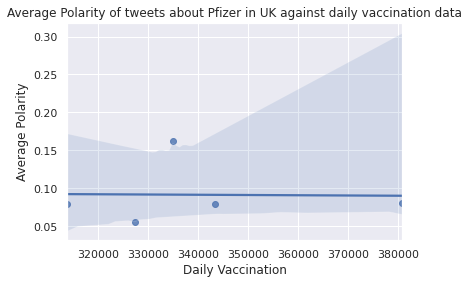

In [35]:
#visualization
try: 
    import pandas as pd
    import matplotlib as plt
    import seaborn as snb
    import os
    os.chdir("/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine")
    
    snb.set()
    scatterplot_pf_UK_plot = snb.regplot(x = "daily_vaccinations", y = "avg(polarity)", data = scatterplot_pf_UK)
    scatterplot_pf_UK_plot.set_title("Average Polarity of tweets about Pfizer in UK against daily vaccination data")
    scatterplot_pf_UK_plot.set_xlabel("Daily Vaccination")
    scatterplot_pf_UK_plot.set_ylabel("Average Polarity")
    fig = scatterplot_pf_UK_plot.get_figure()
    fig.savefig("scatterplot_pf_UK.png", bbox_inches='tight')
except:
    print("Unexpected error:", sys.exc_info()[0])

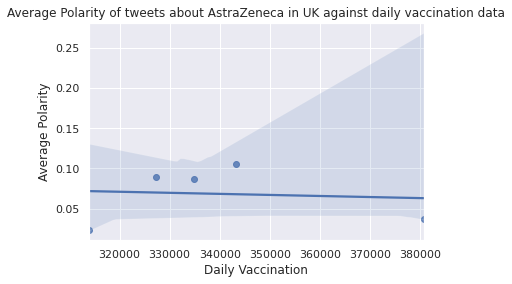

In [36]:
try:
    snb.set()
    scatterplot_astra_UK_plot = snb.regplot(x = "daily_vaccinations", y = "avg(polarity)", data = scatterplot_astra_UK)
    scatterplot_astra_UK_plot.set_title("Average Polarity of tweets about AstraZeneca in UK against daily vaccination data")
    scatterplot_astra_UK_plot.set_xlabel("Daily Vaccination")
    scatterplot_astra_UK_plot.set_ylabel("Average Polarity")
    fig = scatterplot_astra_UK_plot.get_figure()
    fig.savefig("scatterplot_astra_UK.png", bbox_inches='tight')
except: 
    print("Unexpected error:", sys.exc_info()[0])

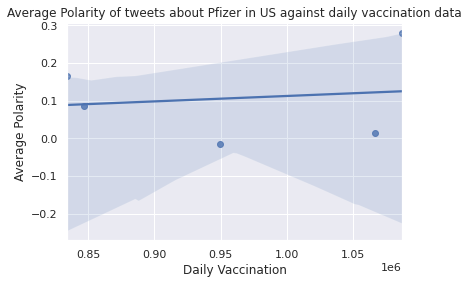

In [37]:
try:
    snb.set()
    scatterplot_pf_US_plot = snb.regplot(x = "daily_vaccinations", y = "avg(polarity)", data = scatterplot_pf_US)
    scatterplot_pf_US_plot.set_title("Average Polarity of tweets about Pfizer in US against daily vaccination data")
    scatterplot_pf_US_plot.set_xlabel("Daily Vaccination")
    scatterplot_pf_US_plot.set_ylabel("Average Polarity")
    fig = scatterplot_pf_US_plot.get_figure()
    fig.savefig("scatterplot_pf_US.png", bbox_inches='tight')
except: 
    print("Unexpected error:", sys.exc_info()[0])

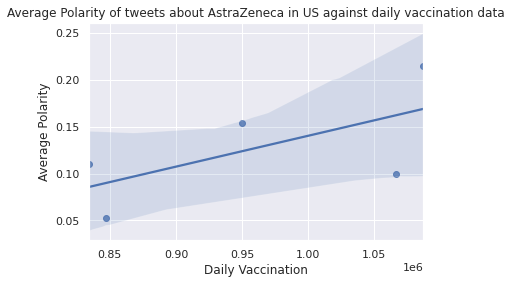

In [38]:
try:
    snb.set()
    scatterplot_astra_US_plot = snb.regplot(x = "daily_vaccinations", y = "avg(polarity)", data = scatterplot_astra_US)
    scatterplot_astra_US_plot.set_title("Average Polarity of tweets about AstraZeneca in US against daily vaccination data")
    scatterplot_astra_US_plot.set_xlabel("Daily Vaccination")
    scatterplot_astra_US_plot.set_ylabel("Average Polarity")
    fig = scatterplot_astra_US_plot.get_figure()
    fig.savefig("scatterplot_astra_US.png", bbox_inches='tight')
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [39]:
try:
    #dataframe for all polarity averages for the two vaccine brands for US&UK
    avg_join = avg_pol_pfizer_UK.join(avg_pol_astra_UK, ["date"])
    avg_join = avg_join.join(avg_pol_pfizer_US, ["date"])
    avg_join = avg_join.join(avg_pol_astra_US, ["date"])

    #renaming the columns
    newColumns = ["date","Pol_Pfizer_UK","Pol_Astra_UK","Pol_Pfizer_US","Pol_Astra_US"]
    avg_pol_join = avg_join.toDF(*newColumns)

    avg_pol_join.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+----------+--------------------+--------------------+--------------------+-------------------+
|      date|       Pol_Pfizer_UK|        Pol_Astra_UK|       Pol_Pfizer_US|       Pol_Astra_US|
+----------+--------------------+--------------------+--------------------+-------------------+
|2021-06-28| 0.08035743103778743| 0.03683097186413678|  0.1666666716337204|0.11027911195999279|
|2021-06-29|  0.0795519224754194| 0.10594220887869596| 0.08641170788932284|0.05216582176710313|
|2021-06-30|  0.1623149226352419| 0.08722826194666002|-0.01490971555366...|0.15395827916391353|
|2021-07-01|0.055742297376341676|  0.0891431685951021|0.013209262108873753|0.09988392184999201|
|2021-07-02|  0.0794737833692173|0.023035714328289034|  0.2801947523539345|0.21465192574101524|
+----------+--------------------+--------------------+--------------------+-------------------+



In [40]:
try:
    ### vacccination data ###
    vacs = spark.read.csv("/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/vacc_data.csv", header = True)

    df_vaccinations = vacs.select(vacs.location, vacs.date, vacs.daily_vaccinations) #selecting the columns needed
    print(df_vaccinations.dtypes) #all our columns are strings, we need the date to be in a date format

    df_vaccinations = df_vaccinations.withColumn("date", to_date(df_vaccinations.date, "yyyy-MM-dd")) #converting to date format
    df_vaccinations = df_vaccinations.withColumn("daily_vaccinations", df_vaccinations.daily_vaccinations.cast(DoubleType()))
    print(df_vaccinations.dtypes) 
    df_vaccinations.select("date").dtypes #checking whether it worked 
    df_vaccinations = df_vaccinations.where("date BETWEEN '2021-05-01' AND '2021-07-02'") #filter for the dates we want

    countries = ["United Kingdom"] #countries we are focusing on
    df_vaccinations_UK = df_vaccinations.filter(df_vaccinations.location.isin(countries)) #filtering for the countries
    df_vaccinations_UK.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

[('location', 'string'), ('date', 'string'), ('daily_vaccinations', 'string')]
[('location', 'string'), ('date', 'date'), ('daily_vaccinations', 'double')]
+--------------+----------+------------------+
|      location|      date|daily_vaccinations|
+--------------+----------+------------------+
|United Kingdom|2021-05-01|          503641.0|
|United Kingdom|2021-05-02|          492543.0|
|United Kingdom|2021-05-03|          464646.0|
|United Kingdom|2021-05-04|          448798.0|
|United Kingdom|2021-05-05|          441126.0|
|United Kingdom|2021-05-06|          440317.0|
|United Kingdom|2021-05-07|          444809.0|
|United Kingdom|2021-05-08|          458007.0|
|United Kingdom|2021-05-09|          461576.0|
|United Kingdom|2021-05-10|          482546.0|
|United Kingdom|2021-05-11|          496918.0|
|United Kingdom|2021-05-12|          510250.0|
|United Kingdom|2021-05-13|          514372.0|
|United Kingdom|2021-05-14|          516464.0|
|United Kingdom|2021-05-15|          519423.0

In [41]:
try:
    ### vacccination data ###
    vacs = spark.read.csv("/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/vacc_data.csv", header = True)

    df_vaccinations = vacs.select(vacs.location, vacs.date, vacs.daily_vaccinations) #selecting the columns needed
    print(df_vaccinations.dtypes) #all our columns are strings, we need the date to be in a date format

    df_vaccinations = df_vaccinations.withColumn("date", to_date(df_vaccinations.date, "yyyy-MM-dd")) #converting to date format
    df_vaccinations = df_vaccinations.withColumn("daily_vaccinations", df_vaccinations.daily_vaccinations.cast(DoubleType()))
    print(df_vaccinations.dtypes) 
    df_vaccinations.select("date").dtypes #checking whether it worked 
    df_vaccinations = df_vaccinations.where("date BETWEEN '2021-05-01' AND '2021-07-02'") #filter for the dates we want

    countries = ["United States"] #countries we are focusing on
    df_vaccinations_US = df_vaccinations.filter(df_vaccinations.location.isin(countries)) #filtering for the countries
    df_vaccinations_US.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

[('location', 'string'), ('date', 'string'), ('daily_vaccinations', 'string')]
[('location', 'string'), ('date', 'date'), ('daily_vaccinations', 'double')]
+-------------+----------+------------------+
|     location|      date|daily_vaccinations|
+-------------+----------+------------------+
|United States|2021-05-01|         2546144.0|
|United States|2021-05-02|         2418580.0|
|United States|2021-05-03|         2287393.0|
|United States|2021-05-04|         2194483.0|
|United States|2021-05-05|         2132487.0|
|United States|2021-05-06|         2087608.0|
|United States|2021-05-07|         2088522.0|
|United States|2021-05-08|         1983391.0|
|United States|2021-05-09|         2017931.0|
|United States|2021-05-10|         2117025.0|
|United States|2021-05-11|         2194787.0|
|United States|2021-05-12|         2159146.0|
|United States|2021-05-13|         2088962.0|
|United States|2021-05-14|         1951333.0|
|United States|2021-05-15|         1926448.0|
|United States|2

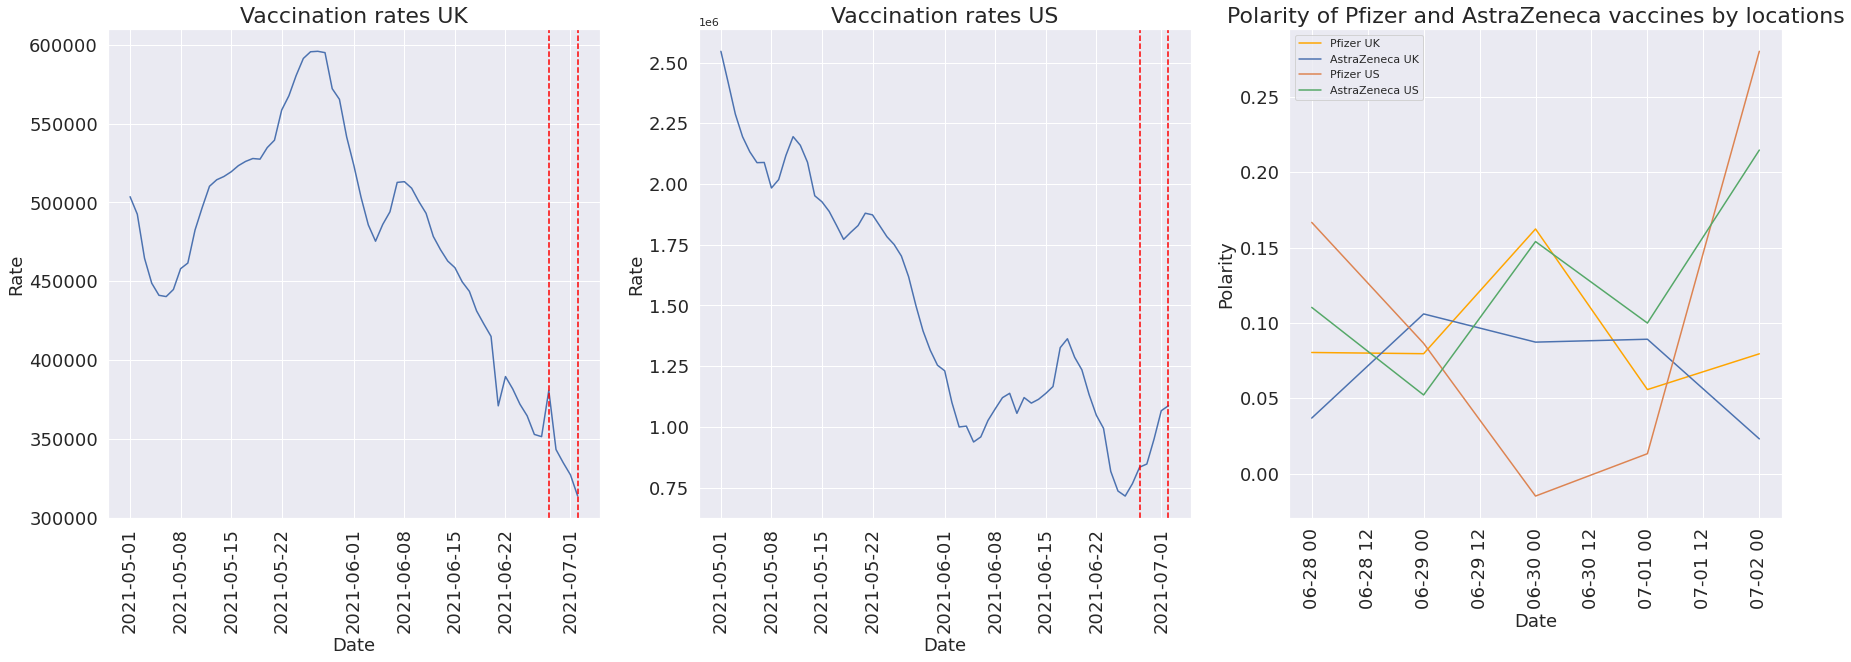

In [42]:
try:
    from matplotlib import *
    import sys
    from pylab import *

    df_vaccinations_UK_pd = df_vaccinations_UK.toPandas()
    avg_pol_join_pd = avg_pol_join.toPandas()
    plt.figure(figsize=(30, 9))       
    plt.subplot(1,3,1)
    plt.plot(df_vaccinations_UK_pd["date"], df_vaccinations_UK_pd["daily_vaccinations"])
    plt.axvline(x='2021-06-28', color='red', linestyle='dashed')
    plt.axvline(x='2021-07-02', color='red', linestyle='dashed')
    plt.xticks(rotation = 90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title("Vaccination rates UK", fontsize=22)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Rate", fontsize=18)
    
    df_vaccinations_US_pd = df_vaccinations_US.toPandas()       
    plt.subplot(1,3,2)
    plt.plot(df_vaccinations_US_pd["date"], df_vaccinations_US_pd["daily_vaccinations"])
    plt.axvline(x='2021-06-28', color='red', linestyle='dashed')
    plt.axvline(x='2021-07-02', color='red', linestyle='dashed')
    plt.xticks(rotation = 90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title("Vaccination rates US", fontsize=22)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Rate", fontsize=18)

    plt.subplot(1,3,3)
    plt.plot(avg_pol_join_pd["date"],avg_pol_join_pd["Pol_Pfizer_UK"], label = "Pfizer UK", color = "orange")
    plt.plot(avg_pol_join_pd["date"],avg_pol_join_pd["Pol_Astra_UK"],label = "AstraZeneca UK")
    plt.plot(avg_pol_join_pd["date"],avg_pol_join_pd["Pol_Pfizer_US"], label = "Pfizer US")
    plt.plot(avg_pol_join_pd["date"],avg_pol_join_pd["Pol_Astra_US"], label = "AstraZeneca US")
    plt.xticks(rotation = 90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title("Polarity of Pfizer and AstraZeneca vaccines by locations", fontsize=22)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Polarity", fontsize=18)

    plt.legend()
    plt.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

## Linear Regression Models

In [43]:
try:
    final_pfizer_UK = final_pfizer_UK.withColumn("daily_vaccinations", final_pfizer_UK.daily_vaccinations.cast(DoubleType()))
    final_astra_UK = final_astra_UK.withColumn("daily_vaccinations", final_astra_UK.daily_vaccinations.cast(DoubleType()))
    final_pfizer_US = final_pfizer_US.withColumn("daily_vaccinations", final_pfizer_US.daily_vaccinations.cast(DoubleType()))
    final_astra_US = final_astra_US.withColumn("daily_vaccinations", final_astra_US.daily_vaccinations.cast(DoubleType()))
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [44]:
try:
    final_pfizer_UK.printSchema()
    final_astra_UK.printSchema()
    final_pfizer_US.printSchema()
    final_astra_US.printSchema()
except: 
    print("Unexpected error:", sys.exc_info()[0])

root
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- daily_vaccinations: double (nullable = true)
 |-- avg(polarity): double (nullable = true)
 |-- avg(subjectivity): double (nullable = true)

root
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- daily_vaccinations: double (nullable = true)
 |-- avg(polarity): double (nullable = true)
 |-- avg(subjectivity): double (nullable = true)

root
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- daily_vaccinations: double (nullable = true)
 |-- avg(polarity): double (nullable = true)
 |-- avg(subjectivity): double (nullable = true)

root
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- daily_vaccinations: double (nullable = true)
 |-- avg(polarity): double (nullable = true)
 |-- avg(subjectivity): double (nullable = true)



In [45]:
# descriptive statistics
final_pfizer_UK.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
location,5,None,None,United Kingdom,United Kingdom
daily_vaccinations,5,340042.0,25227.045219367246,313838.0,380779.0
avg(polarity),5,0.09148807137880154,0.04094175478456811,0.055742297376341676,0.1623149226352419
avg(subjectivity),5,0.3006725775060331,0.06451937819945361,0.23000700366409385,0.40398160621677476


In [46]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    import six

    for i in final_pfizer_UK.columns:
        if i != "date":
            if not(isinstance(final_pfizer_UK.select(i).take(1)[0][0], six.string_types)):
                print("Correlation to Daily Vaccination Rates for", i, final_pfizer_UK.stat.corr('daily_vaccinations',i))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Correlation to Daily Vaccination Rates for daily_vaccinations 1.0
Correlation to Daily Vaccination Rates for avg(polarity) -0.019762450605331272
Correlation to Daily Vaccination Rates for avg(subjectivity) -0.11842169044971075


In [47]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    for i in final_astra_UK.columns:
        if i != "date":
            if not(isinstance(final_astra_UK.select(i).take(1)[0][0], six.string_types)):
                print("Correlation to Daily Vaccination Rates for", i, final_astra_UK.stat.corr('daily_vaccinations',i))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Correlation to Daily Vaccination Rates for daily_vaccinations 1.0
Correlation to Daily Vaccination Rates for avg(polarity) -0.09125138920137307
Correlation to Daily Vaccination Rates for avg(subjectivity) -0.017634668378965674


In [48]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    for i in final_pfizer_US.columns:
        if i != "date":
            if not(isinstance(final_pfizer_US.select(i).take(1)[0][0], six.string_types)):
                print("Correlation to Daily Vaccination Rates for", i, final_pfizer_US.stat.corr('daily_vaccinations',i))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Correlation to Daily Vaccination Rates for daily_vaccinations 1.0
Correlation to Daily Vaccination Rates for avg(polarity) 0.14170371120999786
Correlation to Daily Vaccination Rates for avg(subjectivity) 0.4999418511688798


In [49]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    for i in final_astra_US.columns:
        if i != "date":
            if not(isinstance(final_astra_US.select(i).take(1)[0][0], six.string_types)):
                print("Correlation to Daily Vaccination Rates for", i, final_astra_US.stat.corr('daily_vaccinations',i))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Correlation to Daily Vaccination Rates for daily_vaccinations 1.0
Correlation to Daily Vaccination Rates for avg(polarity) 0.6380379996384863
Correlation to Daily Vaccination Rates for avg(subjectivity) 0.30720400268668796


## LR Model of UK Pfizer tweets

In [50]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    from pyspark.ml.feature import VectorAssembler

    vectorAssembler = VectorAssembler(inputCols = ['avg(polarity)'], outputCol = 'features')
    vfinal_pfizer_UK = vectorAssembler.transform(final_pfizer_UK)
    vfinal_pfizer_UK = vfinal_pfizer_UK.select(['features', 'daily_vaccinations'])
    vfinal_pfizer_UK.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+------------------+
|            features|daily_vaccinations|
+--------------------+------------------+
|[0.08035743103778...|          380779.0|
|[0.0795519224754194]|          343345.0|
|[0.1623149226352419]|          334964.0|
|[0.05574229737634...|          327284.0|
|[0.0794737833692173]|          313838.0|
+--------------------+------------------+



In [51]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # running the Linear regression model
    from pyspark.ml.regression import LinearRegression

    lr = LinearRegression(featuresCol = 'features', labelCol='daily_vaccinations', maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(vfinal_pfizer_UK)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Coefficients: [-12170.425633726267]
Intercept: 341155.4487690887


In [52]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # performance indicators
    trainingSummary = lr_model.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
except: 
    print("Unexpected error:", sys.exc_info()[0])

RMSE: 22559.348576
r2: 0.000391


In [53]:
try:
    # approximately 0.04% of the variability in “daily vaccinations” can be explained by average sentiment polarity

    # RMSE measures the differences between predicted values and actual values. 
    # RMSE alone is meaningless until we compare with the actual “daily_vaccinations” value, such as mean, min and max. 
    # After such comparison, our RMSE looks acceptable with 22559.348576
    vfinal_pfizer_UK.describe().show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+-------+------------------+
|summary|daily_vaccinations|
+-------+------------------+
|  count|                 5|
|   mean|          340042.0|
| stddev|25227.045219367246|
|    min|          313838.0|
|    max|          380779.0|
+-------+------------------+



## LR Model of UK AstraZeneca tweets

In [54]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    vectorAssembler = VectorAssembler(inputCols = ['avg(polarity)'], outputCol = 'features')
    vfinal_astra_UK = vectorAssembler.transform(final_astra_UK)
    vfinal_astra_UK = vfinal_astra_UK.select(['features', 'daily_vaccinations'])
    vfinal_astra_UK.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+------------------+
|            features|daily_vaccinations|
+--------------------+------------------+
|[0.03683097186413...|          380779.0|
|[0.10594220887869...|          343345.0|
|[0.08722826194666...|          334964.0|
|[0.0891431685951021]|          327284.0|
|[0.02303571432828...|          313838.0|
+--------------------+------------------+



In [55]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # running the Linear regression model
    lr = LinearRegression(featuresCol = 'features', labelCol='daily_vaccinations', maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(vfinal_astra_UK)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Coefficients: [-63541.51624906753]
Intercept: 344390.53134400846


In [56]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # performance indicators
    trainingSummary = lr_model.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
except: 
    print("Unexpected error:", sys.exc_info()[0])

RMSE: 22469.616697
r2: 0.008327


In [57]:
try:
    # approximately 0.8% of the variability in “daily vaccinations” can be explained by average sentiment polarity

    # RMSE measures the differences between predicted values and actual values. 
    # RMSE alone is meaningless until we compare with the actual “daily_vaccinations” value, such as mean, min and max. 
    # After such comparison, our RMSE looks acceptable with 22469.616697
    vfinal_astra_UK.describe().show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+-------+------------------+
|summary|daily_vaccinations|
+-------+------------------+
|  count|                 5|
|   mean|          340042.0|
| stddev|25227.045219367246|
|    min|          313838.0|
|    max|          380779.0|
+-------+------------------+



## LR Model of US Pfizer tweets

In [58]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    vectorAssembler = VectorAssembler(inputCols = ['avg(polarity)'], outputCol = 'features')
    vfinal_pfizer_US = vectorAssembler.transform(final_pfizer_US)
    vfinal_pfizer_US = vfinal_pfizer_US.select(['features', 'daily_vaccinations'])
    vfinal_pfizer_US.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+------------------+
|            features|daily_vaccinations|
+--------------------+------------------+
|[0.1666666716337204]|          833990.0|
|[0.08641170788932...|          847000.0|
|[-0.0149097155536...|          949925.0|
|[0.01320926210887...|         1066443.0|
|[0.2801947523539345]|         1087156.0|
+--------------------+------------------+



In [59]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # running the Linear regression model
    lr = LinearRegression(featuresCol = 'features', labelCol='daily_vaccinations', maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(vfinal_pfizer_US)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Coefficients: [139923.86627197644]
Intercept: 942026.8591258437


In [60]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # performance indicators
    trainingSummary = lr_model.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
except: 
    print("Unexpected error:", sys.exc_info()[0])

RMSE: 104948.876980
r2: 0.020080


In [61]:
try:
    # approximately 2% of the variability in “daily vaccinations” can be explained by average sentiment polarity

    # RMSE measures the differences between predicted values and actual values. 
    # RMSE alone is meaningless until we compare with the actual “daily_vaccinations” value, such as mean, min and max. 
    # After such comparison, our RMSE looks slightly high with 104948.876980
    vfinal_pfizer_US.describe().show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+-------+------------------+
|summary|daily_vaccinations|
+-------+------------------+
|  count|                 5|
|   mean|          956902.8|
| stddev|118532.50932845387|
|    min|          833990.0|
|    max|         1087156.0|
+-------+------------------+



## LR Model of US AstraZeneca

In [62]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    vectorAssembler = VectorAssembler(inputCols = ['avg(polarity)'], outputCol = 'features')
    vfinal_astra_US = vectorAssembler.transform(final_astra_US)
    vfinal_astra_US = vfinal_astra_US.select(['features', 'daily_vaccinations'])
    vfinal_astra_US.show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+------------------+
|            features|daily_vaccinations|
+--------------------+------------------+
|[0.11027911195999...|          833990.0|
|[0.05216582176710...|          847000.0|
|[0.15395827916391...|          949925.0|
|[0.09988392184999...|         1066443.0|
|[0.21465192574101...|         1087156.0|
+--------------------+------------------+



In [63]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # running the Linear regression model
    lr = LinearRegression(featuresCol = 'features', labelCol='daily_vaccinations', maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(vfinal_astra_US)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
except: 
    print("Unexpected error:", sys.exc_info()[0])

Coefficients: [1234121.6498181073]
Intercept: 801171.6891486495


In [64]:
try:
    '''
    https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a
    '''
    # performance indicators
    trainingSummary = lr_model.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
except: 
    print("Unexpected error:", sys.exc_info()[0])

RMSE: 81634.915590
r2: 0.407092


In [65]:
try:
    # approximately 40.7% of the variability in “daily vaccinations” can be explained by average sentiment polarity

    # RMSE measures the differences between predicted values and actual values. 
    # RMSE alone is meaningless until we compare with the actual “daily_vaccinations” value, such as mean, min and max. 
    # After such comparison, our RMSE looks slightly high with 81634.915590
    vfinal_astra_US.describe().show()
except: 
    print("Unexpected error:", sys.exc_info()[0])

+-------+------------------+
|summary|daily_vaccinations|
+-------+------------------+
|  count|                 5|
|   mean|          956902.8|
| stddev|118532.50932845387|
|    min|          833990.0|
|    max|         1087156.0|
+-------+------------------+



## WordCloud Visualization

In [45]:
import sys
!{sys.executable} -m pip install numpy

In [46]:
import sys
!{sys.executable} -m pip install wordcloud

In [47]:
import numpy as np
from os import path
from PIL import Image
# Twird Mask for WordCloud
USA_mask = np.array(Image.open('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/USA.png'))
UK_mask = np.array(Image.open('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/UK.png'))
#USA_mask
#UK_mask


In [48]:
try:
    print(USA_mask.shape[1])
    print(USA_mask.shape[0])
except: 
    print("Unexpected error:", sys.exc_info()[0])

639
482


In [49]:
try:
    print(UK_mask.shape[1])
    print(UK_mask.shape[0])
except: 
    print("Unexpected error:", sys.exc_info()[0])

696
717


In [50]:

# Collecting text into a single string for WordCloud
dataCollect1 = pfizer_UK_df.collect()
#print(type(dataCollect1))
#print(dataCollect1)

text1 = []
for row in dataCollect1:
    text1.append(row['text'])

text_string1 = '\n'.join(text1)
#print(type(text_string1))
#print(text_string1)


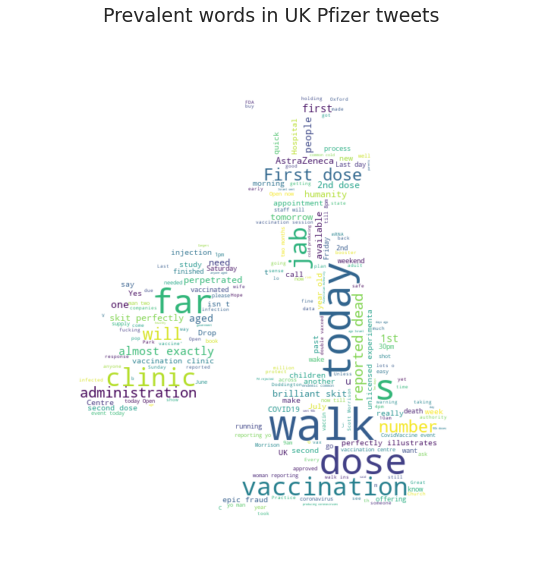

In [51]:
try:
    '''
    https://www.datacamp.com/community/tutorials/wordcloud-python
    '''
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    %matplotlib inline

    # Generate the word cloud from the tweets with mask
    stopwords = STOPWORDS.update(['COVID', 'Pfizer', 'BioNTech', 'Moderna', 'AZ', 'Covid vaccine', 'vaccine', 'vaccines', 'amp'])
    stopwords = set(STOPWORDS)
    cloud_tweets = WordCloud(background_color="white", stopwords=stopwords, mask=UK_mask, width=UK_mask.shape[1],
                   height=UK_mask.shape[0]).generate(text_string1) 
    plt.figure(figsize=(10,10))
    plt.imshow(cloud_tweets, interpolation='bilinear')
    plt.axis("off")
    plt.title('Prevalent words in UK Pfizer tweets', fontsize=19)
    plt.show()

    # Save to png file 
    cloud_tweets.to_file('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/wordcloud_Pfizer_UK.png')
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [52]:
try:
    # Collecting text into a single string for WordCloud
    dataCollect2 = astra_UK_df.collect()
    #print(type(dataCollect2))
    #print(dataCollect2)

    text2 = []
    for row in dataCollect2:
        text2.append(row['text'])

    text_string2 = '\n'.join(text2)
    #print(type(text_string2))
    #print(text_string2)
except: 
    print("Unexpected error:", sys.exc_info()[0])

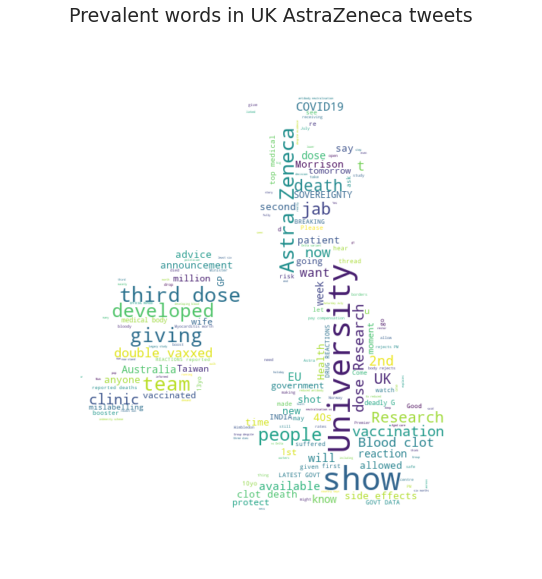

In [53]:
try:
    '''
    https://www.datacamp.com/community/tutorials/wordcloud-python
    '''
    # Generate the word cloud from the tweets with mask
    stopwords = STOPWORDS.update(['AstraZeneca', 'AstraZeneca vaccine', 'Astra Zeneca', 'Oxford', 'vaccine', 'vaccines', 'amp', 's'])
    stopwords = set(STOPWORDS)
    cloud_tweets = WordCloud(background_color="white", stopwords=stopwords, mask=UK_mask, width=UK_mask.shape[1],
                   height=UK_mask.shape[0]).generate(text_string2) 
    plt.figure(figsize=(10,10))
    plt.imshow(cloud_tweets, interpolation='bilinear')
    plt.axis("off")
    plt.title('Prevalent words in UK AstraZeneca tweets', fontsize=19)
    plt.show()

    # Save to png file 
    cloud_tweets.to_file('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/wordcloud_AstraZeneca_UK.png')
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [54]:
try:
    # Collecting text into a single string for WordCloud
    dataCollect3 = pfizer_US_df.collect()
    #print(type(dataCollect3))
    #print(dataCollect3)

    text3 = []
    for row in dataCollect3:
        text3.append(row['text'])

    text_string3 = '\n'.join(text3)
    #print(type(text_string3))
    #print(text_string3)
except: 
    print("Unexpected error:", sys.exc_info()[0])

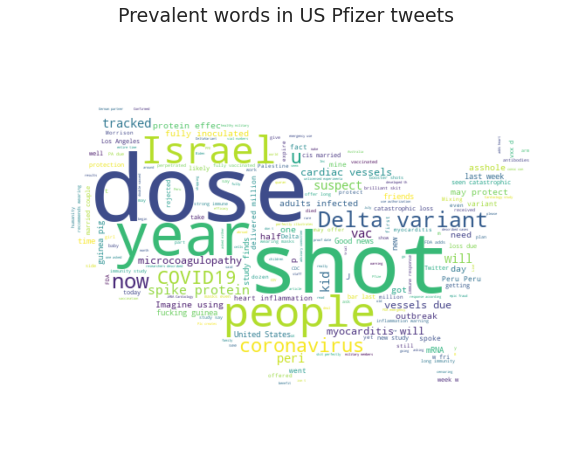

In [55]:
try:
    '''
    https://www.datacamp.com/community/tutorials/wordcloud-python
    '''
    # Generate the word cloud from the tweets with mask
    stopwords = STOPWORDS.update(['COVID', 'Pfizer', 'BioNTech', 'Moderna', 'Covid vaccine', 'vaccine', 'vaccines', 'amp'])
    stopwords = set(STOPWORDS)
    cloud_tweets = WordCloud(background_color="white", stopwords=stopwords, mask=USA_mask, width=USA_mask.shape[1],
                   height=USA_mask.shape[0]).generate(text_string3) 
    plt.figure(figsize=(10,10))
    plt.imshow(cloud_tweets, interpolation='bilinear')
    plt.axis("off")
    plt.title('Prevalent words in US Pfizer tweets', fontsize=19)
    plt.show()

    # Save to png file 
    cloud_tweets.to_file('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/wordcloud_Pfizer_US.png')
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [56]:
try:
    # Collecting text into a single string for WordCloud
    dataCollect4 = astra_US_df.collect()
    #print(type(dataCollect4))
    #print(dataCollect4)

    text4 = []
    for row in dataCollect4:
        text4.append(row['text'])

    text_string4 = '\n'.join(text4)
    #print(type(text_string4))
    #print(text_string4)
except: 
    print("Unexpected error:", sys.exc_info()[0])

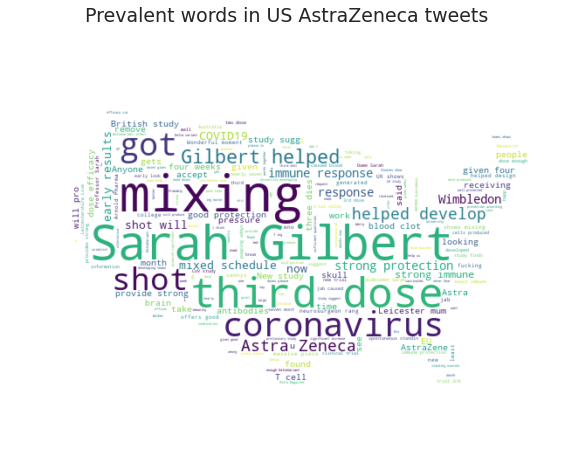

In [57]:
try:
    '''
    https://www.datacamp.com/community/tutorials/wordcloud-python
    '''
    # Generate the word cloud from the tweets with mask
    stopwords = STOPWORDS.update(['AstraZeneca', 'AstraZeneca vaccine', 'Astra Zeneca', 'Oxford', 'vaccine', 'vaccines', 'amp', 's'])
    stopwords = set(STOPWORDS)
    cloud_tweets = WordCloud(background_color="white", stopwords=stopwords, mask=USA_mask, width=USA_mask.shape[1],
                   height=USA_mask.shape[0]).generate(text_string4) 
    plt.figure(figsize=(10,10))
    plt.imshow(cloud_tweets, interpolation='bilinear')
    plt.axis("off")
    plt.title('Prevalent words in US AstraZeneca tweets', fontsize=19)
    plt.show()

    # Save to png file 
    cloud_tweets.to_file('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/wordcloud_AstraZeneca_US.png')
except: 
    print("Unexpected error:", sys.exc_info()[0])